In [2]:
%load_ext watermark
%watermark -v -m -p numpy,scipy,matplotlib,sklearn,pandas,torch

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.27.0

numpy     : 1.26.4
scipy     : 1.13.1
matplotlib: 3.9.2
sklearn   : 1.5.2
pandas    : 2.2.2
torch     : 2.3.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 154 Stepping 3, GenuineIntel
CPU cores   : 12
Architecture: 64bit



### Imports

In [3]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np
import os
import random
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary  # For model summary
import time


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [5]:
set_all_seeds(42)

In [6]:
RANDOM_SEED = 42
BATCH_SIZE = 256
NUM_EPOCHS = 50
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cpu')

In [7]:
import torch

print(torch.cuda.is_available())
# print(torch.cuda.device_count())
# print(torch.cuda.get_device_name(0))

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Available devices: {torch.cuda.device_count()}")
# print(f"Device name: {torch.cuda.get_device_name(0)}")
torch.cuda.empty_cache()


False
Available devices: 0


### Load Data

In [8]:
# Define transformations (resize and conversion to tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for consistency
    transforms.ToTensor()           # Convert to tensor for processing
])

# Set the paths for the image directories
output_dir_base = './reduced_data'
output_dir_sparrow_train = os.path.join(output_dir_base, 'sparrow', 'train')
output_dir_swan_train = os.path.join(output_dir_base, 'swan', 'train')
output_dir_sparrow_test = os.path.join(output_dir_base, 'sparrow', 'test')
output_dir_swan_test = os.path.join(output_dir_base, 'swan', 'test')

# Load the training dataset
train_dataset = datasets.ImageFolder(root=output_dir_base, transform=transform)

# Load the testing dataset
test_dataset = datasets.ImageFolder(root=output_dir_base, transform=transform)

# Create the training DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create the testing DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Example: Print the number of batches in each DataLoader
print(f'Number of training batches: {len(train_loader)}')
print(f'Number of testing batches: {len(test_loader)}')

# Example of iterating over train_loader
for images, labels in train_loader:
    print(f'Batch of images with shape: {images.shape}')
    print(f'Batch of labels with shape: {labels.shape}')
    break  # Just showing the first batch as an example

# Example of iterating over test_loader
for images, labels in test_loader:
    print(f'Batch of images with shape: {images.shape}')
    print(f'Batch of labels with shape: {labels.shape}')
    break  # Just showing the first batch as an example

Number of training batches: 7
Number of testing batches: 7
Batch of images with shape: torch.Size([32, 3, 224, 224])
Batch of labels with shape: torch.Size([32])
Batch of images with shape: torch.Size([32, 3, 224, 224])
Batch of labels with shape: torch.Size([32])


### Baseline CNN model

In [9]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 3 input channels (RGB), 16 filters
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling with 2x2 filter
        self.fc1 = nn.Linear(16 * 112 * 112, 128)  # Flattened dimensions after convolution and pooling
        self.fc2 = nn.Linear(128, 1)  # Final output layer with 1 unit for binary classification

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)  # Apply ReLU activation
        x = self.pool(x)  # Apply max pooling
        x = x.view(-1, 16 * 112 * 112)  # Flatten the output of conv layer
        x = self.fc1(x)  # Fully connected layer
        x = nn.ReLU()(x)  # Apply ReLU activation
        x = self.fc2(x)  # Final output (logits for binary classification)
        return x

# Instantiate the model
model = CNNModel()

# Define optimizer and loss function
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for logits

summary(model, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
         MaxPool2d-2         [-1, 16, 112, 112]               0
            Linear-3                  [-1, 128]      25,690,240
            Linear-4                    [-1, 1]             129
Total params: 25,690,817
Trainable params: 25,690,817
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 7.66
Params size (MB): 98.00
Estimated Total Size (MB): 106.23
----------------------------------------------------------------


In [10]:
model = CNNModel().to(DEVICE)

# Define optimizer and loss function
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for logits

# Store metrics for plotting
train_losses = []
train_accuracies = []
test_accuracies = []

### Setting up Tensorboard Logging

In [11]:
from torch.utils.tensorboard import SummaryWriter
import time

# Initialize TensorBoard writer
writer = SummaryWriter("runs/CNN_experiment")

# Updated train function with enhanced logging
def train(model, train_loader, test_loader, criterion, optimizer, num_epochs=20):
    model.train()  # Set the model to training mode
    start_time = time.time()  # Track training time

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels.float().view(-1, 1))  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item()
            # Calculate accuracy for the batch
            preds = (outputs > 0).float()
            correct += (preds == labels.view(-1, 1)).sum().item()
            total += labels.size(0)

            # Log to TensorBoard per iteration
            writer.add_scalar('Training Loss', loss.item(), epoch * len(train_loader) + i)
            writer.add_scalar('Training Accuracy', correct / total, epoch * len(train_loader) + i)

            if i % 10 == 9:  # Print and log every 10 mini-batches
                print(f"Epoch {epoch + 1} | Iteration {i + 1} | Loss: {running_loss / 10:.4f} | Accuracy: {correct / total:.4f}")
                running_loss = 0.0

        # Log training accuracy for the epoch and append values for later plotting
        train_accuracy = correct / total
        train_losses.append(running_loss / len(train_loader))  # Average loss for the epoch
        train_accuracies.append(train_accuracy)
        
        writer.add_scalar('Training Accuracy Epoch', train_accuracy, epoch)
        writer.add_scalar('Training Loss Epoch', running_loss / len(train_loader), epoch)

        # Log the training progress for VS Code (print every epoch)
        print(f"\nEpoch {epoch + 1} | Training Accuracy: {train_accuracy:.4f} | Training Loss: {running_loss / len(train_loader):.4f}")
        
        # Add separator after every 10 epochs
        if (epoch + 1) % 10 == 0:
            print("\n" + "-" * 50 + "\n")

        # Testing loop for accuracy and loss (every epoch)
        model.eval()  # Set the model to evaluation mode
        test_correct = 0
        test_total = 0
        test_loss = 0.0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels.float().view(-1, 1))  # Calculate loss for test
                test_loss += loss.item()
                preds = (outputs > 0).float()
                test_correct += (preds == labels.view(-1, 1)).sum().item()
                test_total += labels.size(0)

        test_accuracy = test_correct / test_total
        test_accuracies.append(test_accuracy)

        # Log testing accuracy and loss
        writer.add_scalar('Testing Accuracy', test_accuracy, epoch)
        writer.add_scalar('Testing Loss', test_loss / len(test_loader), epoch)

        # Log the testing progress for VS Code (print every epoch)
        print(f"Epoch {epoch + 1} | Testing Accuracy: {test_accuracy:.4f} | Testing Loss: {test_loss / len(test_loader):.4f}")

        model.train()  # Switch back to training mode

    training_time = time.time() - start_time
    writer.add_text("Training Time", f"{training_time:.2f} seconds")
    writer.add_text("Model Parameters", f"{sum(p.numel() for p in model.parameters())}")

    # Close the writer when done
    writer.close()
    print(f"\nTraining completed in {training_time:.2f} seconds")

    # Optionally, you can save these values to a file for plotting later
    return train_losses, train_accuracies, test_accuracies



Epoch 1 | Training Accuracy: 0.5600 | Training Loss: 0.7057
Epoch 1 | Testing Accuracy: 0.5700 | Testing Loss: 0.6774

Epoch 2 | Training Accuracy: 0.6600 | Training Loss: 0.6500
Epoch 2 | Testing Accuracy: 0.7500 | Testing Loss: 0.5972

Epoch 3 | Training Accuracy: 0.6900 | Training Loss: 0.5987
Epoch 3 | Testing Accuracy: 0.6700 | Testing Loss: 0.5571

Epoch 4 | Training Accuracy: 0.7250 | Training Loss: 0.5636
Epoch 4 | Testing Accuracy: 0.7700 | Testing Loss: 0.5135

Epoch 5 | Training Accuracy: 0.7700 | Training Loss: 0.5068
Epoch 5 | Testing Accuracy: 0.7300 | Testing Loss: 0.5066

Epoch 6 | Training Accuracy: 0.7550 | Training Loss: 0.5005
Epoch 6 | Testing Accuracy: 0.7750 | Testing Loss: 0.4831

Epoch 7 | Training Accuracy: 0.7850 | Training Loss: 0.4987
Epoch 7 | Testing Accuracy: 0.7200 | Testing Loss: 0.4892

Epoch 8 | Training Accuracy: 0.7700 | Training Loss: 0.4838
Epoch 8 | Testing Accuracy: 0.7750 | Testing Loss: 0.4863

Epoch 9 | Training Accuracy: 0.7800 | Training 

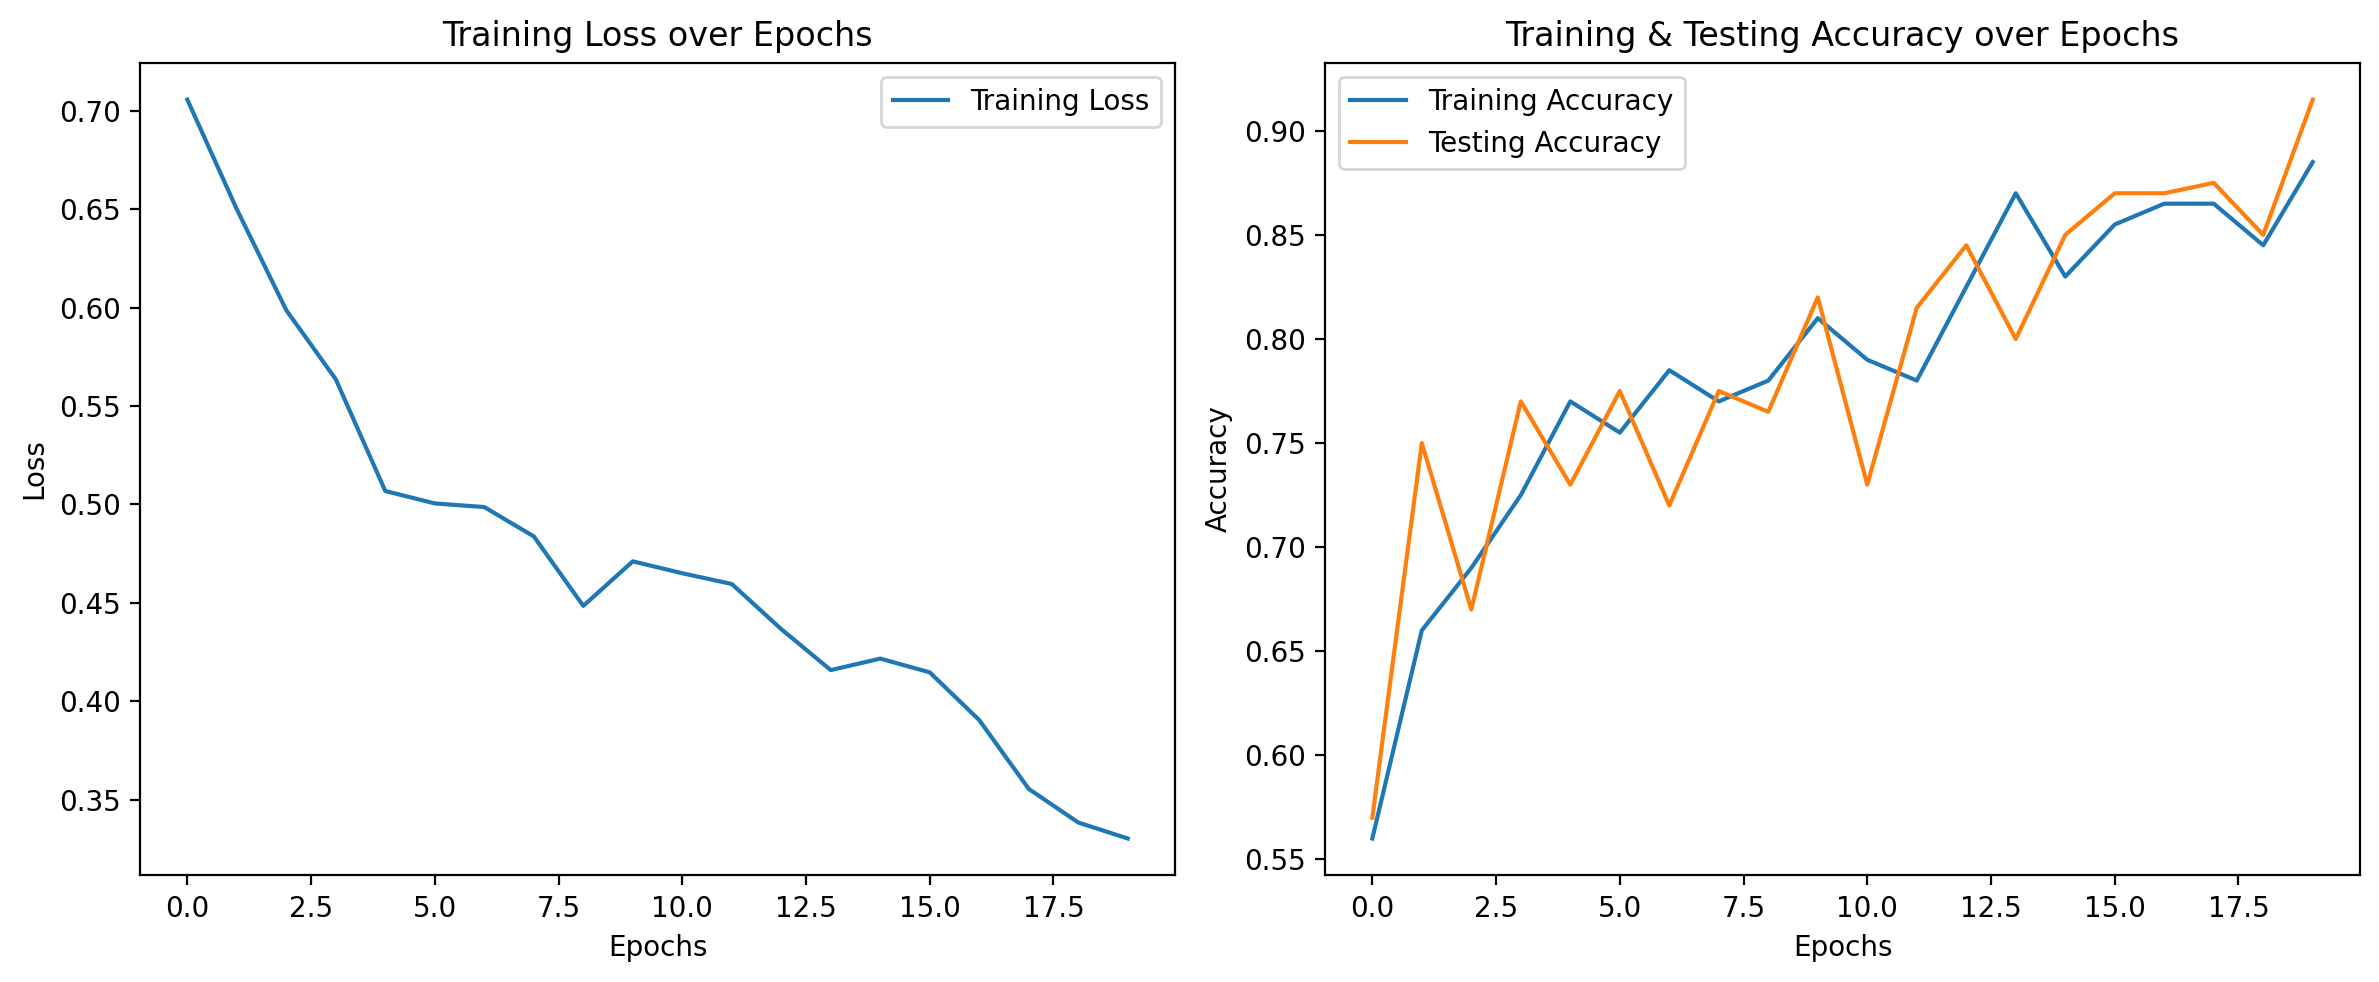

In [12]:
import matplotlib.pyplot as plt

# Assuming you have these lists from the training function
train_losses, train_accuracies, test_accuracies = train(model, train_loader, test_loader, criterion, optimizer)

# Plotting the training loss and accuracy
plt.figure(figsize=(12, 5))

# Training loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Training & Testing accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Testing Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


### Model 1 :1 Block

In [13]:
# Define the 1-block VGG model (single block with Conv2D, ReLU, MaxPool)
class VGG1Block(nn.Module):
    def __init__(self, num_classes=1):
        super(VGG1Block, self).__init__()
        
        # First and only Block: Conv2D(32) -> ReLU -> MaxPool
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Conv Layer with 32 filters
            nn.ReLU(),  # ReLU Activation
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max Pooling with 2x2 kernel
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 100 * 100, 128)  # Flattened size after convolution (assuming input size 200x200)
        self.fc2 = nn.Linear(128, num_classes)  # Output layer for binary classification
        self.sigmoid = nn.Sigmoid()  # Sigmoid for binary classification output
        
    def forward(self, x):
        # Pass input through the convolutional block
        x = self.block1(x)
        
        # Flatten the output from the convolutional layer
        x = x.view(x.size(0), -1)
        
        # Pass through the fully connected layers
        x = self.fc1(x)
        x = torch.relu(x)  # ReLU activation in the dense layer
        x = self.fc2(x)
        x = self.sigmoid(x)  # Final sigmoid activation for binary classification
        return x

# Example of using the model
model_1block = VGG1Block(num_classes=1)

# Print the model summary (for input size 200x200x3)
summary(model_1block, input_size=(3, 200, 200))

# Example to use with an optimizer (SGD with learning rate of 0.001)
optimizer = optim.SGD(model_1block.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.BCELoss()  # Binary Cross Entropy loss for binary classification


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 200, 200]             896
              ReLU-2         [-1, 32, 200, 200]               0
         MaxPool2d-3         [-1, 32, 100, 100]               0
            Linear-4                  [-1, 128]      40,960,128
            Linear-5                    [-1, 1]             129
           Sigmoid-6                    [-1, 1]               0
Total params: 40,961,153
Trainable params: 40,961,153
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 21.97
Params size (MB): 156.25
Estimated Total Size (MB): 178.69
----------------------------------------------------------------


In [14]:
# Define the 3-block VGG model (all layers in one class)
class VGG3Block(nn.Module):
    def __init__(self, num_classes=1):
        super(VGG3Block, self).__init__()
        
        # First Block: Conv2D(32) -> ReLU -> MaxPool
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Conv Layer with 32 filters
            nn.ReLU(),  # ReLU Activation
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max Pooling with 2x2 kernel
        )
        
        # Second Block: Conv2D(64) -> ReLU -> MaxPool
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Conv Layer with 64 filters
            nn.ReLU(),  # ReLU Activation
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max Pooling with 2x2 kernel
        )
        
        # Third Block: Conv2D(128) -> ReLU -> MaxPool
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Conv Layer with 128 filters
            nn.ReLU(),  # ReLU Activation
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max Pooling with 2x2 kernel
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 25 * 25, 128)  # Flattened size after convolution
        self.fc2 = nn.Linear(128, num_classes)  # Output layer for binary classification
        self.sigmoid = nn.Sigmoid()  # Sigmoid for binary classification output
        
    def forward(self, x):
        # Pass input through the convolutional blocks
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        
        # Flatten the output from convolutional layers
        x = x.view(x.size(0), -1)
        
        # Pass through the fully connected layers
        x = self.fc1(x)
        x = torch.relu(x)  # ReLU activation in the dense layer
        x = self.fc2(x)
        x = self.sigmoid(x)  # Final sigmoid activation for binary classification
        return x

# Example of using the model
model_3block = VGG3Block(num_classes=1)

# Print the model summary (for input size 200x200x3)
summary(model_3block, input_size=(3, 200, 200))

# Example to use with an optimizer (SGD with learning rate of 0.001)
optimizer = optim.SGD(model_3block.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.BCELoss()  # Binary Cross Entropy loss for binary classification


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 200, 200]             896
              ReLU-2         [-1, 32, 200, 200]               0
         MaxPool2d-3         [-1, 32, 100, 100]               0
            Conv2d-4         [-1, 64, 100, 100]          18,496
              ReLU-5         [-1, 64, 100, 100]               0
         MaxPool2d-6           [-1, 64, 50, 50]               0
            Conv2d-7          [-1, 128, 50, 50]          73,856
              ReLU-8          [-1, 128, 50, 50]               0
         MaxPool2d-9          [-1, 128, 25, 25]               0
           Linear-10                  [-1, 128]      10,240,128
           Linear-11                    [-1, 1]             129
          Sigmoid-12                    [-1, 1]               0
Total params: 10,333,505
Trainable params: 10,333,505
Non-trainable params: 0
-------------------------